# Backtesting an ML strategy with Backtrader

## Imports and Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import csv
from time import time
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [3]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commision Setup

In [135]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

### DataFrame Loader

In [136]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [137]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Strategy

In [138]:
# Includes an option to only trade on certain weekdays in lines 39/40.

class MLStrategy(bt.Strategy):
    params = (('n_positions', 10),
              ('min_positions', 5),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        for data in self.datas:
            print(data.datetime)
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')

        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

### Create and Configure Cerebro Instance

In [139]:
cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)

# from datetime import datetime

# start_date_str = '2020-01-01'
# end_date_str = '2022-01-01'

# start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
# end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

cerebro.broker.setcash(cash)

### Add input data

In [140]:
### Add input data

idx = pd.IndexSlice
data = pd.read_hdf('backtest.h5', 'data').sort_index()
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)

In [141]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 751 entries, 2020-01-31 to 2023-01-24
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   predicted       6 non-null      float64
 1   open            751 non-null    float64
 2   high            751 non-null    float64
 3   low             751 non-null    float64
 4   close           751 non-null    float64
 5   adjusted_close  751 non-null    float64
 6   volume          751 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 46.9 KB


,predicted,open,high,low,close,adjusted_close,volume
date,,,,,,,
2020-01-31,NaN,137.60,137.97,134.000,134.21,131.6288,2582313
2020-02-03,NaN,134.73,137.47,134.200,135.52,132.9136,2376967
2020-02-04,NaN,137.08,139.44,136.690,138.97,136.2972,1839782
2020-02-05,NaN,139.96,140.30,137.545,137.89,135.2380,1507609
2020-02-06,NaN,137.96,139.10,136.870,138.97,136.2972,2206858


### Run Strategy Backtest

In [142]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=25, min_positions=20, 
                    verbose=True, log_file='bt_log.csv')
start = time()

try:
    results = cerebro.run()
except Exception as e:
    print(f"Error during cerebro.run(): {e}")

ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

KeyboardInterrupt: 

### Plot result

In [ ]:
# Disabled because large number of datafeeds all plot separately.

# cerebro.plot()  # plot the results
# figure = cerebro.plot(style='candlebars')[0][0]
# figure.savefig(f'backtrader.png')

### Get `pyfolio` inputs

In [4]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns2')
positions.to_hdf('backtrader.h5', 'positions2')
transactions.to_hdf('backtrader.h5', 'transactions2/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev2')

NameError: name 'results' is not defined

## Run pyfolio analysis

In [5]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')

In [6]:
benchmark = web.DataReader('SP500', 'fred', '2020', '2023').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [7]:
daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

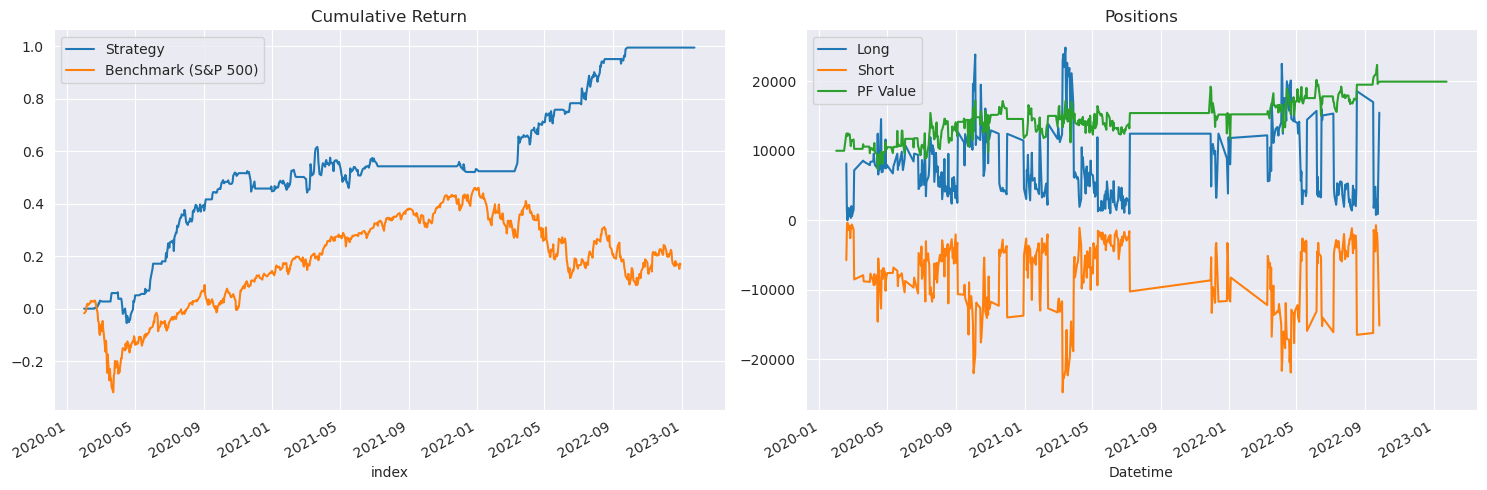

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

df = returns.to_frame('Strategy').join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

In [9]:
data.head()

NameError: name 'data' is not defined

In [ ]:
positions = positions.reset_index()
positions.head()

,Datetime,ZTS,cash
0,2020-01-31 00:00:00+00:00,0.0,10000.0
1,2020-02-03 00:00:00+00:00,0.0,10000.0
2,2020-02-04 00:00:00+00:00,0.0,10000.0
3,2020-02-05 00:00:00+00:00,0.0,10000.0
4,2020-02-06 00:00:00+00:00,0.0,10000.0


In [ ]:
transactions.head()

,amount,price,sid,symbol,value
date,,,,,
2020-02-18 00:00:00+00:00,1,315.36,1,AAPL,-315.36
2020-02-18 00:00:00+00:00,-4,89.42,3,ABT,357.68
2020-02-18 00:00:00+00:00,-1,212.50,4,ACN,212.50
2020-02-18 00:00:00+00:00,7,54.94,10,AMD,-384.58
2020-02-18 00:00:00+00:00,-6,63.36,16,ATVI,380.16


In [ ]:
benchmark.head()

DATE
2020-01-01 00:00:00+00:00         NaN
2020-01-02 00:00:00+00:00         NaN
2020-01-03 00:00:00+00:00   -0.007060
2020-01-06 00:00:00+00:00    0.003533
2020-01-07 00:00:00+00:00   -0.002803
Name: SP500, dtype: float64

In [10]:
returns.head()

index
2020-01-31 00:00:00+00:00    0.0
2020-02-03 00:00:00+00:00    0.0
2020-02-04 00:00:00+00:00    0.0
2020-02-05 00:00:00+00:00    0.0
2020-02-06 00:00:00+00:00    0.0
Name: return, dtype: float64

Start date,2020-01-31
End date,2023-01-24
Total months,35
,Backtest
Annual return,26.1%
Cumulative returns,99.5%
Annual volatility,12.8%
Sharpe ratio,1.88
Calmar ratio,2.36
Stability,0.83
Max drawdown,-11.0%


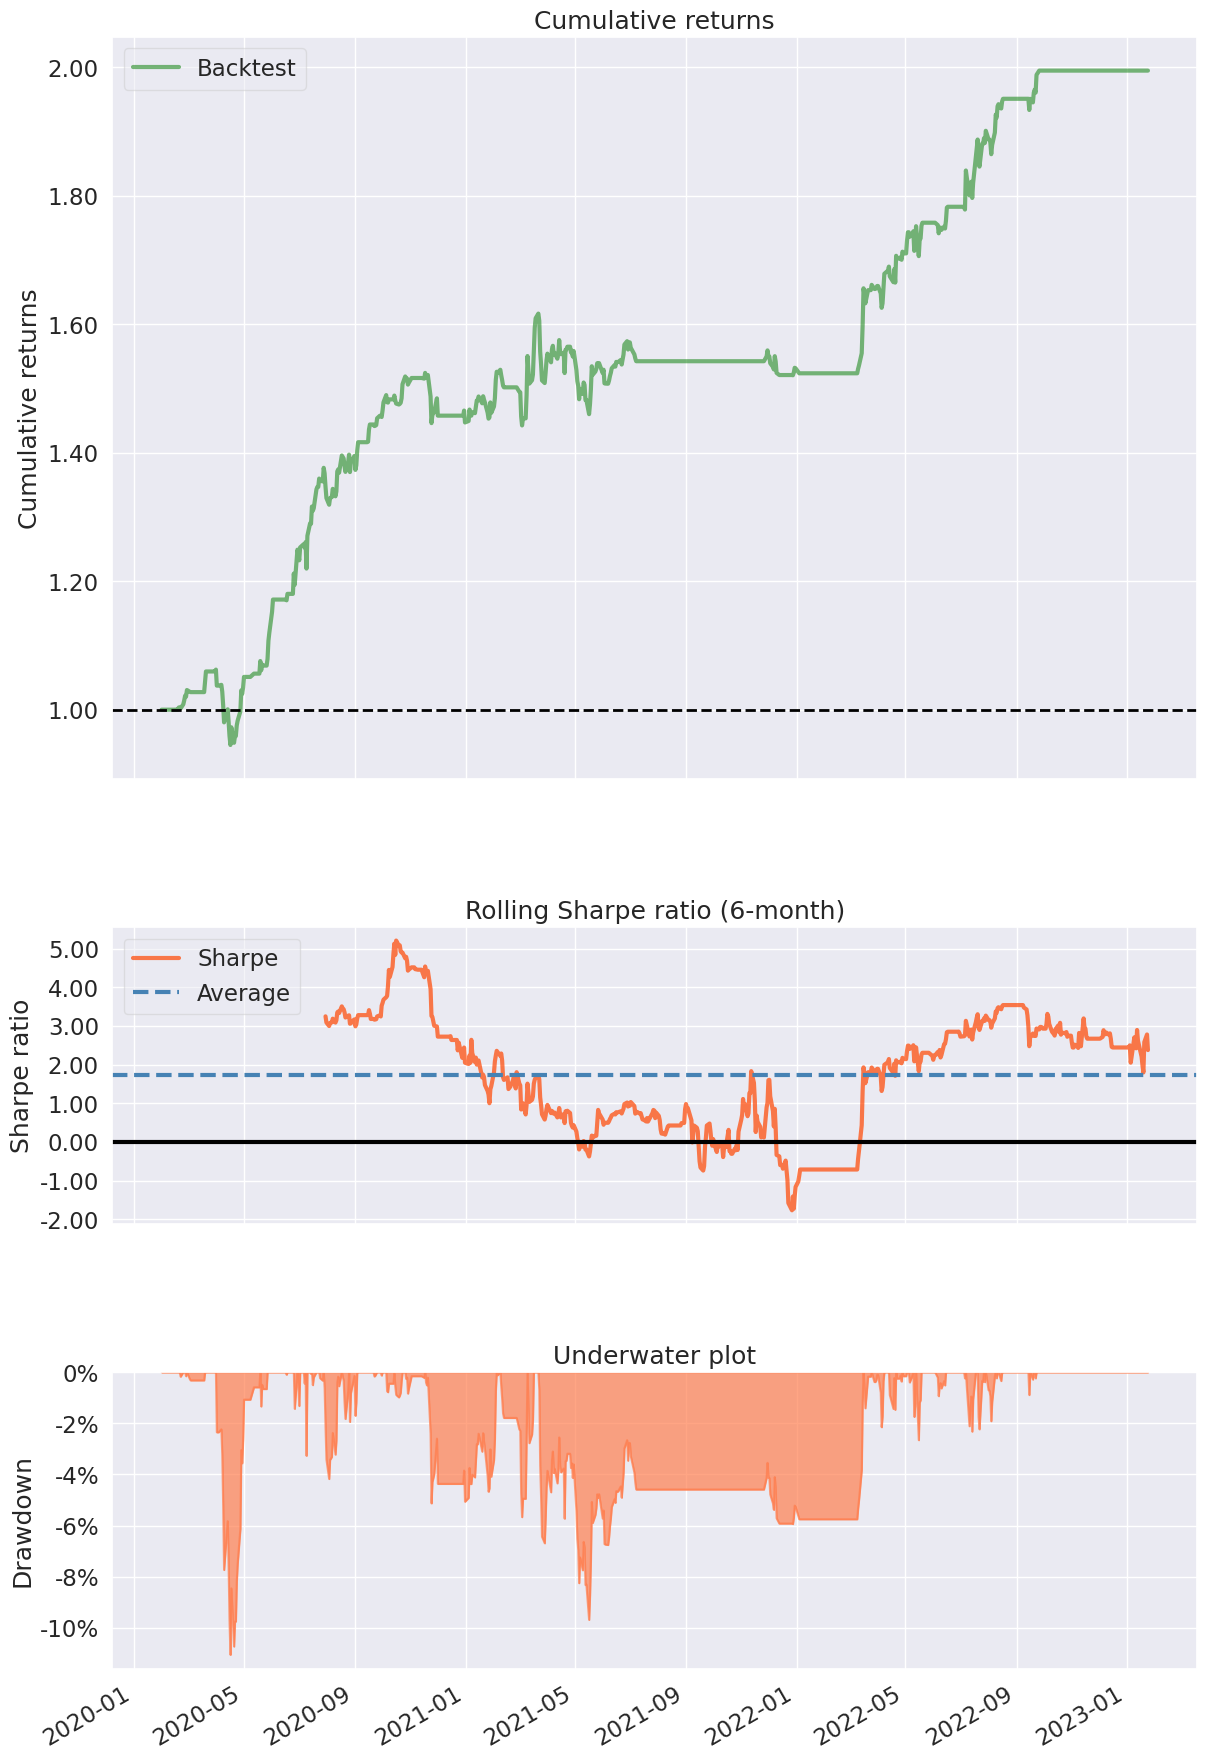

In [14]:
# pf.create_full_tear_sheet(returns,
#                           transactions=transactions,
#                           positions=positions,
#                           benchmark_rets=benchmark.dropna())

pf.create_simple_tear_sheet(returns)#,
                        #   transactions=transactions,
                        #   positions=positions,
                        #   benchmark_rets=benchmark.dropna())